In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Window Datasetnya
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# Untuk Plot Series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Load Dataset

In [ ]:
# Nama file dataset
ds_komoditas = "Cabai Merah Keriting"

df = pd.read_csv(f'{ds_komoditas}.csv')
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')
# set the Date column be the index of our dataset
df.set_index('Date', inplace=True)

temps = df['Price'].values.astype('float32')
time_step = df.index.values

prices = np.array(temps)

# Normalisasi Dataset

In [ ]:
def normalize_dataset(prices):
    min = np.min(prices)
    max = np.max(prices)
    prices = prices - min
    prices = prices / (max - min)
    return prices

max = np.max(temps)
min = np.min(temps)

time = np.array(time_step)
prices = normalize_dataset(temps)
print(np.max(prices))
print(np.min(prices))

print(max)
print(min)

1.0
0.0
80000.0
8000.0


## Train Validation Split

In [ ]:
# Split Dataset
split_time = int(len(prices) * 0.7)
print()
time_train = time[:split_time]
x_train = prices[:split_time]
time_valid = time[split_time:]
x_valid = prices[split_time:]

In [ ]:
# Hyperparameter
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# Window Dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# Mendefinisikan Model

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=64, kernel_size=5,
#                            strides=1, padding="causal",
#                            activation="relu",
#                            input_shape=[None, 1]),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation="relu"),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * max)
# ])

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv1D(filters=64, kernel_size=5,
#                            strides=1, padding="causal",
#                            activation="relu",
#                            input_shape=[None, 1]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * max)
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='same', activation="relu", input_shape=[None, 1]),
    tf.keras.layers.AveragePooling1D(),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 average_pooling1d (Average  (None, None, 60)          0         
 Pooling1D)                                                      
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 120)               7320      
                                                                 
 dense_1 (Dense)             (None, 10)                1210      
                                                        

In [ ]:
# Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',  # Quantity to be monitored.
    patience=15,  # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True
)

# Compile
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

# Fit
history = model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping])

# #Add Lambda Layer to Denormalize the data
# model.add(tf.keras.layers.Lambda(lambda x: x * (max-min) + min))

Epoch 1/500
17/17 [==============================] - 7s 104ms/step - loss: 0.0760 - mae: 0.2051 - val_loss: 0.0148 - val_mae: 0.0781
Epoch 2/500
17/17 [==============================] - 1s 43ms/step - loss: 0.0267 - mae: 0.1253 - val_loss: 0.0142 - val_mae: 0.0800
Epoch 3/500
17/17 [==============================] - 1s 47ms/step - loss: 0.0216 - mae: 0.1103 - val_loss: 0.0157 - val_mae: 0.0808
Epoch 4/500
17/17 [==============================] - 1s 48ms/step - loss: 0.0200 - mae: 0.1049 - val_loss: 0.0149 - val_mae: 0.0794
Epoch 5/500
17/17 [==============================] - 1s 78ms/step - loss: 0.0188 - mae: 0.1028 - val_loss: 0.0142 - val_mae: 0.0781
Epoch 6/500
17/17 [==============================] - 1s 53ms/step - loss: 0.0183 - mae: 0.1016 - val_loss: 0.0141 - val_mae: 0.0775
Epoch 7/500
17/17 [==============================] - 1s 44ms/step - loss: 0.0181 - mae: 0.1012 - val_loss: 0.0140 - val_mae: 0.0774
Epoch 8/500
17/17 [==============================] - 1s 42ms/step - loss: 0

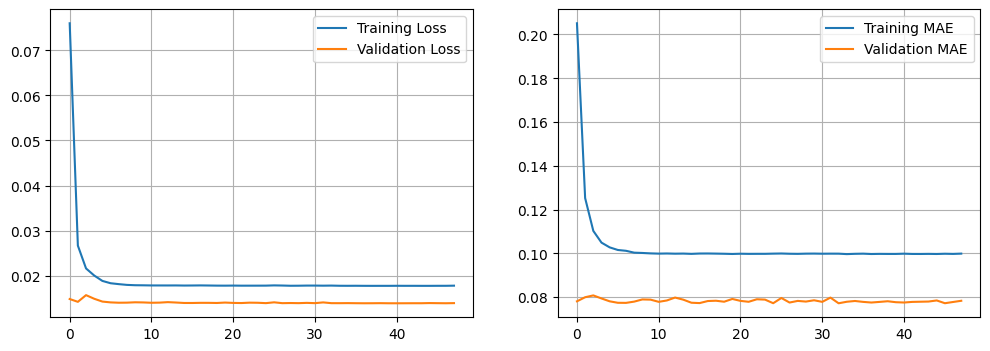

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.grid(True)

plt.show()

# Kita Tes Yagesya

In [ ]:
!pip install tf2onnx
!git clone https://github.com/Microsoft/MMdnn.git
!pip3 install -e MMdnn/
import tf2onnx
import onnx
model.save('cabai-merah-v2.keras')
model.save('cabai-merah-v2')

Cloning into 'MMdnn'...
remote: Enumerating objects: 7238, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 7238 (delta 6), reused 11 (delta 5), pack-reused 7218
Receiving objects: 100% (7238/7238), 36.35 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (5097/5097), done.
Obtaining file:///content/MMdnn
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdnn


In [ ]:
!python -m tf2onnx.convert --saved-model cabai-merah-v2/ --output cabai-merah-v2.onnx
!mmconvert -sf keras -iw cabai-merah-v2.keras -df onnx -om cabai-merah-v2.onnx

Traceback (most recent call last):
  File "<frozen importlib._bootstrap_external>", line 1372, in _path_importer_cache
KeyError: '/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/keras/src/__init__.py", line 21, in <module>
    from keras.src import models
  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/__init__.py", line 18, in <module>
    from keras.src.engine.functional import Functional
  File "/usr/local/lib/python3.10/dist-pa

In [ ]:
forecast = []
for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 29ms/step


In [ ]:
#print(results)
print(np.min(results) * (max-min) + min)
print(results * (max-min) + min)

21197.14
[36276.125 36252.926 36207.477 36134.83  36038.016 35912.45  35759.29
 35561.16  35366.797 35177.82  34985.234 34745.12  34454.14  34151.79
 33842.758 33542.117 33241.805 32959.547 32671.354 32368.016 32039.29
 31725.938 31426.842 31149.016 30882.555 30629.62  30399.37  30208.24
 30051.12  29954.756 29848.133 29728.799 29575.973 29400.81  29196.314
 28983.875 28781.203 28598.982 28400.562 28180.574 27961.457 27732.809
 27503.23  27280.8   27065.018 26851.379 26646.3   26453.082 26272.152
 26094.525 25909.88  25709.473 25524.164 25341.094 25164.693 24983.496
 24792.129 24596.713 24392.348 24193.46  24015.064 23860.457 23731.238
 23617.303 23530.86  23478.32  23419.605 23350.389 23260.602 23178.305
 23094.617 23020.86  22935.531 22859.078 22792.373 22721.79  22648.355
 22572.314 22497.23  22422.8   22336.637 22212.834 22066.9   21926.475
 21786.031 21639.96  21506.918 21376.469 21268.91  21198.275 21197.14
 21216.37  21249.79  21298.398 21330.215 21333.379 21341.615 21380.203
 2

# Visualisasi Hasil Prediksi Pada Validation Set

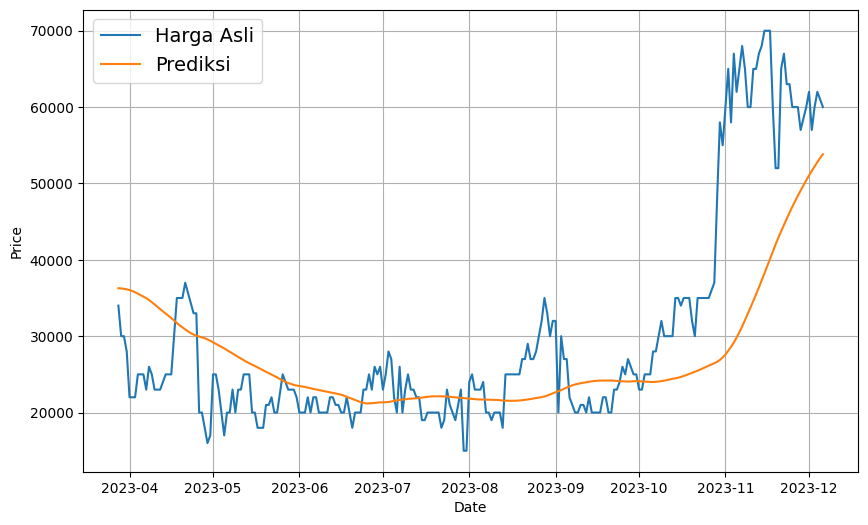

In [ ]:
# Plot Forecasting
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid * (max-min) + min, label="Harga Asli")
plot_series(time_valid, results * (max-min) + min, label='Prediksi')
plt.show()

In [ ]:
# Convert x_valid and results to pandas Series
x_valid_series = pd.Series(x_valid * (max-min) + min, index=time_valid)
results_series = pd.Series(results * (max-min) + min, index=time_valid)

# Concatenate the two Series to create a DataFrame
df_results = pd.concat([x_valid_series, results_series], axis=1)

# Rename the columns
df_results.columns = ['x_valid', 'predictions']

print(df_results)

            x_valid   predictions
2023-03-28  34000.0  36276.125000
2023-03-29  30000.0  36252.925781
2023-03-30  30000.0  36207.476562
2023-03-31  28000.0  36134.828125
2023-04-01  22000.0  36038.015625
...             ...           ...
2023-12-02  57000.0  51657.304688
2023-12-03  60000.0  52231.289062
2023-12-04  62000.0  52791.734375
2023-12-05  61000.0  53327.449219
2023-12-06  60000.0  53827.984375

[254 rows x 2 columns]


In [ ]:
model.save('cabai_merah-v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model v2

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape=[None, 1], activation='relu'),
    tf.keras.layers.GRU(16, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Callback untuk mencegah overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True
)

#Training Model
model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/100
17/17 [==============================] - 7s 123ms/step - loss: 0.1743 - mae: 0.3486 - val_loss: 0.0401 - val_mae: 0.1357
Epoch 2/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0596 - mae: 0.1901 - val_loss: 0.0492 - val_mae: 0.1925
Epoch 3/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0465 - mae: 0.1721 - val_loss: 0.0223 - val_mae: 0.1178
Epoch 4/100
17/17 [==============================] - 1s 78ms/step - loss: 0.0428 - mae: 0.1659 - val_loss: 0.0287 - val_mae: 0.1393
Epoch 5/100
17/17 [==============================] - 2s 107ms/step - loss: 0.0420 - mae: 0.1633 - val_loss: 0.0252 - val_mae: 0.1277
Epoch 6/100
17/17 [==============================] - 2s 103ms/step - loss: 0.0413 - mae: 0.1627 - val_loss: 0.0272 - val_mae: 0.1344
Epoch 7/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0405 - mae: 0.1607 - val_loss: 0.0237 - val_mae: 0.1232
Epoch 8/100
17/17 [==============================] - 1s 62ms/step - loss:

In [ ]:
forecast = []
for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 25ms/step


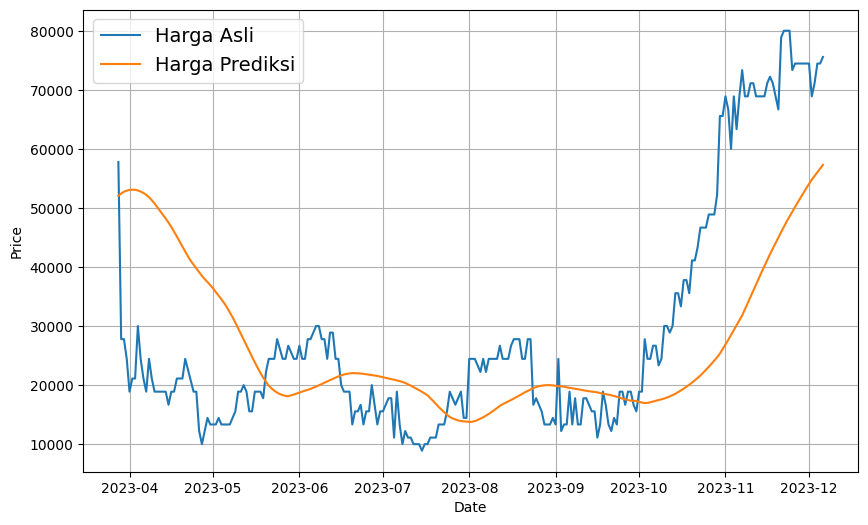

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_step[split_time:], x_valid * max, label='Harga Asli')
plot_series(time_step[split_time:], results * max, label='Harga Prediksi')

plt.show()

In [ ]:
#Number of future predictions
future_forecast = 30

#Use the last window_size data points for the initial sequence
sequence = prices[-window_size:]

#Store the predictions
predictions = []

#Loop to predict future dates
for i in range(future_forecast):
    # Reshape the sequence
    sequence_reshaped = sequence[-window_size:].reshape(1, window_size)

#Predict the next data point
    predicted_value = model.predict(sequence_reshaped)[0]

#Append the predicted value to the sequence
    sequence = np.append(sequence, predicted_value)

#Append the predicted value to the predictions
    predictions.append(predicted_value)

predictions = np.array(predictions) * (max-min) + min

1/1 [==============================] - 0s 38ms/step


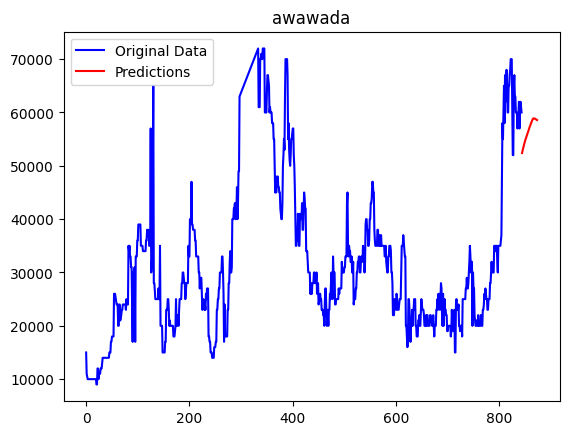

In [ ]:
original_data = prices.tolist()
original_data = np.array(original_data) * (max-min) + min

indices = np.arange(len(original_data) + future_forecast)

plt.plot(indices[:len(original_data)], original_data, label='Original Data', color='blue')

plt.plot(indices[len(original_data):], predictions, label='Predictions', color='red')

plt.title('awawada')
plt.legend()
plt.show()

In [ ]:
model.save("cabai-merah-GRU-v3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tf2onnx
!git clone https://github.com/Microsoft/MMdnn.git
!pip3 install -e MMdnn/
import tf2onnx
import onnx
model.save('cabai-merah-GRU-v3.keras')
model.save('cabai-merah-GRU-v3')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 73.7 MB/s eta 0:00:00
Cloning into 'MMdnn'...
remote: Enumerating objects: 7238, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 7238 (delta 6), reused 11 (delta 5), pack-reused 7218
Receiving objects: 100% (7238/7238), 36.35 MiB | 25.03 MiB/s, done.
Resolving deltas: 100% (5097/5097), done.
Obtaining file:///content/MMdnn
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdnn


# Model GRU v3

# Cabai Rawit Merah

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# Untuk Plot Series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [ ]:
# Nama file dataset
ds_komoditas = "Cabai Rawit Merah"

df = pd.read_csv(f'{ds_komoditas}.csv')
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')
# set the Date column be the index of our dataset
df.set_index('Date', inplace=True)

temps = df['Price'].values.astype('float32')
time_step = df.index.values

prices = np.array(temps)

In [ ]:
def normalize_dataset(prices):
    min = np.min(prices)
    max = np.max(prices)
    prices = prices - min
    prices = prices / (max - min)
    return prices

max = np.max(temps)
min = np.min(temps)

time = np.array(time_step)
prices = normalize_dataset(temps)
print(np.max(prices))
print(np.min(prices))

print(max)
print(min)

1.0
0.0
80000.0
8000.0


In [ ]:
# Split Dataset
split_time = int(len(prices) * 0.7)
print()
time_train = time[:split_time]
x_train = prices[:split_time]
time_valid = time[split_time:]
x_valid = prices[split_time:]

In [ ]:
# Hyperparameter
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# Window Dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation="relu", input_shape=[None, 1]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)

])

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Callback untuk mencegah overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True
)

#Training Model
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
17/17 [==============================] - 10s 178ms/step - loss: 3.3786 - mae: 1.2881 - val_loss: 0.0646 - val_mae: 0.1910
Epoch 2/100
17/17 [==============================] - 1s 68ms/step - loss: 0.1944 - mae: 0.3504 - val_loss: 0.0855 - val_mae: 0.2137
Epoch 3/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0723 - mae: 0.2116 - val_loss: 0.0576 - val_mae: 0.1922
Epoch 4/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0507 - mae: 0.1781 - val_loss: 0.0191 - val_mae: 0.1044
Epoch 5/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0432 - mae: 0.1635 - val_loss: 0.0247 - val_mae: 0.1285
Epoch 6/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0393 - mae: 0.1561 - val_loss: 0.0212 - val_mae: 0.1142
Epoch 7/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0383 - mae: 0.1530 - val_loss: 0.0354 - val_mae: 0.1539
Epoch 8/100
17/17 [==============================] - 1s 67ms/step - loss: 

In [ ]:
forecast = []
for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 26ms/step


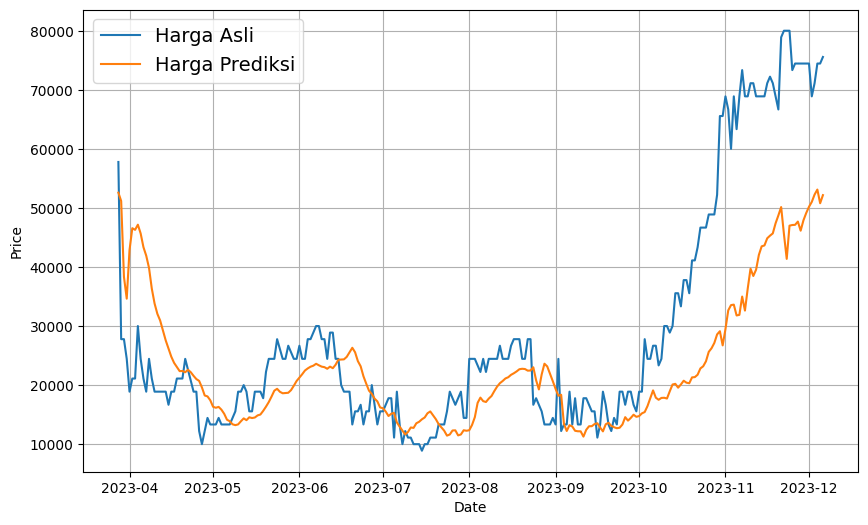

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_step[split_time:], x_valid * max, label='Harga Asli')
plot_series(time_step[split_time:], results * max, label='Harga Prediksi')

plt.show()

In [ ]:
#Number of future predictions
future_forecast = 30

#Use the last window_size data points for the initial sequence
sequence = prices[-window_size:]

#Store the predictions
predictions = []

#Loop to predict future dates
for i in range(future_forecast):
    # Reshape the sequence
    sequence_reshaped = sequence[-window_size:].reshape(1, window_size)

#Predict the next data point
    predicted_value = model.predict(sequence_reshaped)[0]

#Append the predicted value to the sequence
    sequence = np.append(sequence, predicted_value)

#Append the predicted value to the predictions
    predictions.append(predicted_value)

predictions = np.array(predictions) * (max-min) + min

1/1 [==============================] - 0s 25ms/step


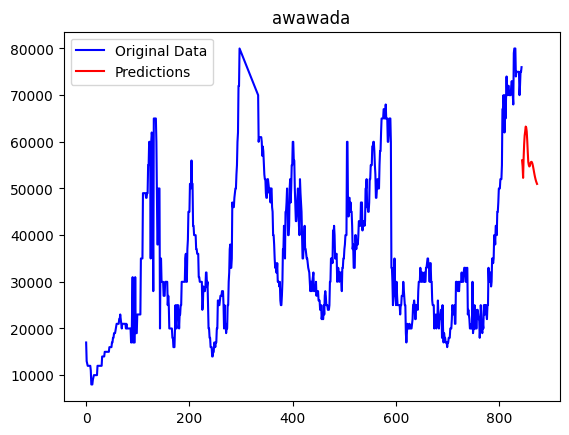

In [ ]:
original_data = prices.tolist()
original_data = np.array(original_data) * (max-min) + min

indices = np.arange(len(original_data) + future_forecast)

plt.plot(indices[:len(original_data)], original_data, label='Original Data', color='blue')

plt.plot(indices[len(original_data):], predictions, label='Predictions', color='red')

plt.title('awawada')
plt.legend()
plt.show()

In [ ]:
model.save(f'{ds_komoditas}-GRU-v3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Beras Medium (GRUv3)

In [ ]:
# Nama file dataset
ds_komoditas = "Beras Medium Penggilingan"

df = pd.read_csv(f'{ds_komoditas}.csv')
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')
# set the Date column be the index of our dataset
df.set_index('Date', inplace=True)

temps = df['Price'].values.astype('float32')
time_step = df.index.values

prices = np.array(temps)

In [ ]:
def normalize_dataset(prices):
    min = np.min(prices)
    max = np.max(prices)
    prices = prices - min
    prices = prices / (max - min)
    return prices

max = np.max(temps)
min = np.min(temps)

time = np.array(time_step)
prices = normalize_dataset(temps)
print(np.max(prices))
print(np.min(prices))

print(max)
print(min)

1.0
0.0
11500.0
9000.0


In [ ]:
# Split Dataset
split_time = int(len(prices) * 0.7)
print()
time_train = time[:split_time]
x_train = prices[:split_time]
time_valid = time[split_time:]
x_valid = prices[split_time:]

In [ ]:
# Hyperparameter
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# Window Dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=[None, 1]),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Callback untuk mencegah overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=10,
    restore_best_weights=True
)

#Training Model
model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/100
17/17 [==============================] - 5s 97ms/step - loss: 0.0050 - mae: 0.0491 - val_loss: 0.0306 - val_mae: 0.1619
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 2.5964e-04 - mae: 0.0097 - val_loss: 0.0020 - val_mae: 0.0374
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 1.5987e-04 - mae: 0.0043 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 4/100
17/17 [==============================] - 0s 16ms/step - loss: 1.4089e-04 - mae: 0.0021 - val_loss: 0.0010 - val_mae: 0.0157
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 1.3606e-04 - mae: 0.0017 - val_loss: 8.9587e-04 - val_mae: 0.0056
Epoch 6/100
17/17 [==============================] - 0s 21ms/step - loss: 1.3499e-04 - mae: 0.0012 - val_loss: 9.0003e-04 - val_mae: 0.0047
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 1.3479e-04 - mae: 0.0014 - val_loss: 9.0966e-04 - val_mae: 0.0048
Epoch 8/100
17/17 [=====================

In [ ]:
forecast = []
for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 45ms/step


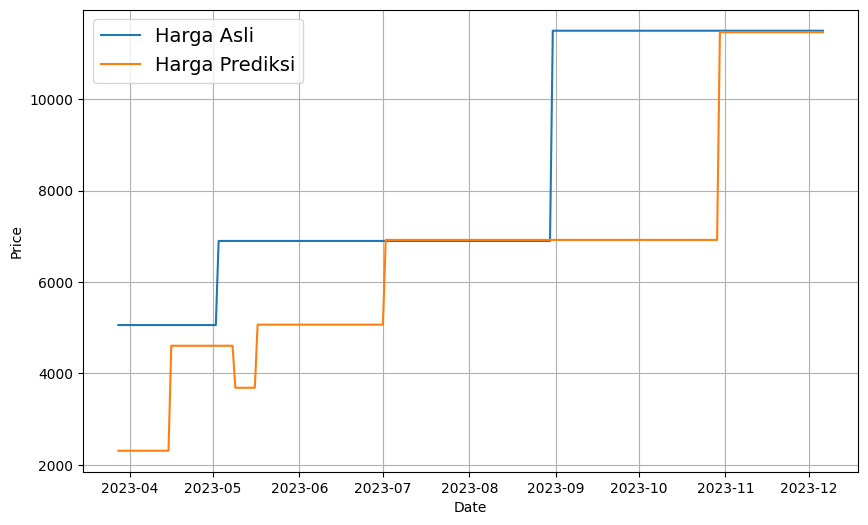

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_step[split_time:], x_valid * max, label='Harga Asli')
plot_series(time_step[split_time:], results * max, label='Harga Prediksi')

plt.show()

In [ ]:
#Number of future predictions
future_forecast = 30

#Use the last window_size data points for the initial sequence
sequence = prices[-window_size:]

#Store the predictions
predictions = []

#Loop to predict future dates
for i in range(future_forecast):
    # Reshape the sequence
    sequence_reshaped = sequence[-window_size:].reshape(1, window_size)

#Predict the next data point
    predicted_value = model.predict(sequence_reshaped)[0]

#Append the predicted value to the sequence
    sequence = np.append(sequence, predicted_value)

#Append the predicted value to the predictions
    predictions.append(predicted_value)

predictions = np.array(predictions) * (max-min) + min

1/1 [==============================] - 0s 21ms/step


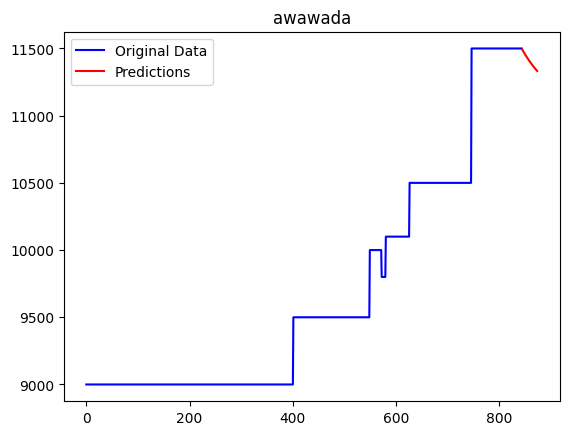

In [ ]:
original_data = prices.tolist()
original_data = np.array(original_data) * (max-min) + min

indices = np.arange(len(original_data) + future_forecast)

plt.plot(indices[:len(original_data)], original_data, label='Original Data', color='blue')

plt.plot(indices[len(original_data):], predictions[:, 0], label='Predictions', color='red')

plt.title('awawada')
plt.legend()
plt.show()

In [ ]:
model.save(f'{ds_komoditas}-Seq-v3.h5')

# Beras Medium